# Retrieving and Aggregating NWM Data for a Spatial Domain

**Authors:** 

<ul style="line-height:1.5;">
<li>Ayman Nassar <a href="mailto:ayman.nassar@usu.edu">(ayman.nassar@usu.edu)</a></li>
<li>Pabitra Dash <a href="mailto:pabitra.dash@usu.edu">(pabitra.dash@usu.edu)</a></li>
<li>Homa Salehabadi <a href="mailto:homa.salehabadi@usu.edu">(homa.salehabadi@usu.edu)</a></li>
<li>David Tarboton <a href="mailto:david.tarboton@usu.edu">(david.tarboton@usu.edu)</a></li>
</ul>

**Last Updated:** 
10/07/2024

**Purpose:**

This notebook provides code examples for retrieving NOAA National Water Model Retrospective data from Amazon Web Services (AWS). It makes it easier for researchers to access data for a specific spatial domain. It also allows for data aggregation at a different time scale than what NOAA originally provided.

**Audience:**

Researchers who are familiar with Jupyter Notebooks, basic Python and basic hydrologic data analysis.

**Description:**

This notebook takes a shapefile specifying the location, start and end dates for the desired period, a variable name, and a preferred time aggregation interval as inputs. It then retrieves data from AWS, aggregates it over the specified time interval, displays the data as a plot, and saves it as a CSV file.

**Data Description:**

This notebook uses data developed and published by NOAA on Amazon Web Services (AWS) as described in detail in this registry of open data entry <https://registry.opendata.aws/nwm-archive/>. The NOAA National Water Model Retrospective dataset contains input and output from multi-decade CONUS retrospective simulations. These simulations used meteorological input fields from meteorological retrospective datasets. The output frequency and fields available in this historical NWM dataset differ from those contained in the real-time operational NWM forecast model. Additionally, note that no streamflow or other data assimilation is performed within any of the NWM retrospective simulations. This notebook uses the Zarr format version of this data. Zarr is a format for storage of chunked, compressed, N-dimensional arrays, designed to support storage using distributed systems such as cloud object stores (<https://zarr.dev/>).

**Software Requirements:**

This notebook has been tested on the CIROH Jupyterhub, CyberGIS Jupyter for Water and CUAHSI JupyterHub deployments. It relies on the general-purpose Jupyter computing environment with the following specific Python libraries: 

>  numpy: 1.26.4     
   geopandas: 0.14.3  
   pandas: 2.2.1  
   matplotlib: 3.8.3   
   contextily: 1.6.2    
   shapely: 2.0.3
 
It also uses code from nwm_utils.py that accompanies this notebook.
 






### 1. Install and Import Python Libraries Needed to Run this Jupyter Notebook

Some libraries such as contextily may not be installed by default in your Python environment, so it has to be installed first before you can work with it. Use the following command to install the contextily library:

In [18]:
!pip install contextily

In [19]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # For adding a basemap
from shapely.geometry import box
from mpl_toolkits.axes_grid1 import make_axes_locatable
from nwm_utils import get_conus_bucket_url, load_dataset, reproject_coordinates, get_fid, get_aggregation_code
from shapely.geometry import Polygon

### 2. Set Inputs

Use the cells in this section of the notebook to set the input values that specify the data to retrieve. An example shapefile for the Great Salt Lake basin is provided as part of this resource.  Upload your own shapefile for a different area.

In [20]:
# Start date in Year-Month-Day format, the earliest start date can be '1979-02-01'
start_datetime = '1980-01-01'

# End date in Year-Month-Day format, the latest end date can be '2023-01-31'
end_datetime = '1980-01-31'

# Shapefile path 
shapefile_path = "./GSLSubbasins/GSLSubbasins.shp"

**Users may select one of the following datasets to retrieve data:**
- Land Surface Model Output
- Terrain Routing Output
- Land Surface Diagnostic Output

For a full list of output variables, refer to the following website: 
<https://ral.ucar.edu/sites/default/files/public/WRFHydroV5_OutputVariableMatrix_V5.pdf>

In [21]:
# User-defined NWM output dataset; see above for a list of valid dataset names.
nwm_out_ds='Land Surface Model Output'

# User-defined variable name - this variable is part of the National Water Model (NWM) output datasets
# For a full list of NWM output variables, refer to the following website: https://ral.ucar.edu/sites/default/files/public/WRFHydroV5_OutputVariableMatrix_V5.pdf
variable_name = 'ACCET'

# User-defined aggregation interval - valid values are 'hour', 'day', 'month', 'year'
agg_interval='hour'

## 3. Virtually Load the Data Array
This block of code maps the input variable and aggregation interval onto the variable encoding used in the Zarr bucket storage.  It then loads the virtual xarray dataset for the variable of interest. 

In [22]:
# Set dictionary to map output name onto associated code used in the AWS bucket storage
nwm_outputs = {
    'Land Surface Model Output': 'ldasout', 
    'Terrain Routing Output': 'rtout', 
    'Land Surface Diagnostic Output': 'lsmout', 
}

# Get the name of the NWM output dataset from the dictionary (nwm_outputs)
variable_code = nwm_outputs[nwm_out_ds]

# Get the variable code for the aggregation interval
agg_code = get_aggregation_code(agg_interval)

# Get the S3 bucket URL for the data path
url = get_conus_bucket_url(variable_code)

# Load the dataset
ds = load_dataset(url)
print(ds)

<xarray.Dataset>
Dimensions:   (time: 128568, y: 3840, x: 4608, vis_nir: 2, soil_layers_stag: 4)
Coordinates:
  * time      (time) datetime64[ns] 1979-02-01T03:00:00 ... 2023-02-01
  * x         (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y         (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Dimensions without coordinates: vis_nir, soil_layers_stag
Data variables: (12/21)
    ACCET     (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    ACSNOM    (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    ALBEDO    (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    ALBSND    (time, y, vis_nir, x) float64 dask.array<chunksize=(224, 350, 1, 350), meta=np.ndarray>
    ALBSNI    (time, y, vis_nir, x) float64 dask.array<chunksize=(224, 350, 1, 350), meta=np.ndarray>
    COSZ      (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    ...        ...
    SNOWH  

### 4. Display Map and Bounding Box

Text(354.069105495887, 0.5, 'Latitude')

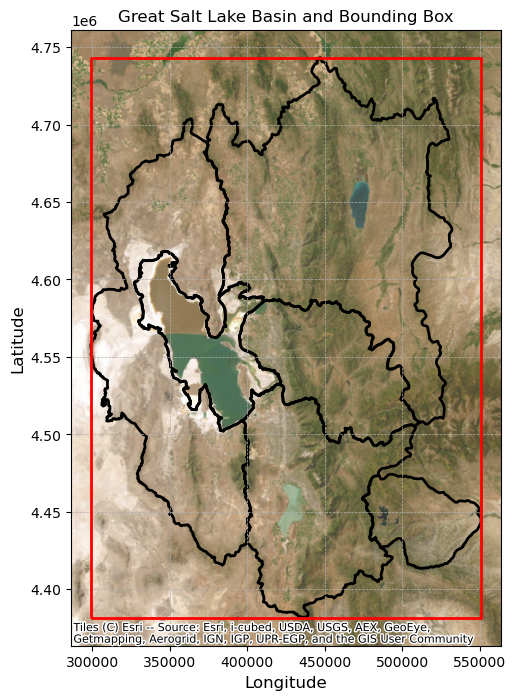

In [23]:
# Read the shapefile using GeoPandas
gdf = gpd.read_file(shapefile_path)

# Get the total bounds of the shapefile
bounds = gdf.total_bounds

# Create a bounding box as a Polygon
bbox = Polygon([(bounds[0], bounds[1]), (bounds[0], bounds[3]), (bounds[2], bounds[3]), (bounds[2], bounds[1]), (bounds[0], bounds[1])])

# Convert the bounding box into a GeoDataFrame
bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs=gdf.crs)  # Ensure it has the same CRS as the gdf

# Create a layout for the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Display the shapefile
ax = gdf.plot( ax=ax, color='none', edgecolor='black', linewidth=2)

# Plot the bounding box on the same plot (using the ax object from the previous plot)
bbox_gdf.boundary.plot(ax=ax, color="red", linewidth=2)

# Add a topographic basemap using contextily 
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf.crs.to_string(), alpha=0.8)

# Add title
ax.set_title("Great Salt Lake Basin and Bounding Box", fontsize=12)

# Add grid lines
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Customize x and y axis labels
ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

### 5. Subset the Data

Data for the specified variable is retrieved and aggregated over the bounding box and to the time interval specified, using sum aggregation Xarray function.  The time step of the input NWM data is hourly.

The results are saved in a data frame ds_subset.df which holds the aggregated variable of interest. 

In [24]:
# Reproject coordinates of the bounding box to match the dataset
x_min, y_min = reproject_coordinates(ds, bounds[0], bounds[1], gdf.crs)
x_max, y_max = reproject_coordinates(ds, bounds[2], bounds[3], gdf.crs)

# Subset the data for the specified period and location
ds_subset = ds[variable_name].sel(y=slice(y_min, y_max), x=slice(x_min, x_max)).loc[dict(time=slice(start_datetime,end_datetime))]
ds_subset_df = ds_subset.mean(['x', 'y']).to_dataframe()
print(ds_subset_df)

                         ACCET
time                          
1980-01-01 00:00:00  22.982853
1980-01-01 03:00:00   0.000210
1980-01-01 06:00:00  -0.002322
1980-01-01 09:00:00  -0.005931
1980-01-01 12:00:00  -0.010912
...                        ...
1980-01-31 09:00:00   5.560417
1980-01-31 12:00:00   5.554516
1980-01-31 15:00:00   5.546668
1980-01-31 18:00:00   5.567849
1980-01-31 21:00:00   5.653437

[248 rows x 1 columns]


### 6. Plot Data

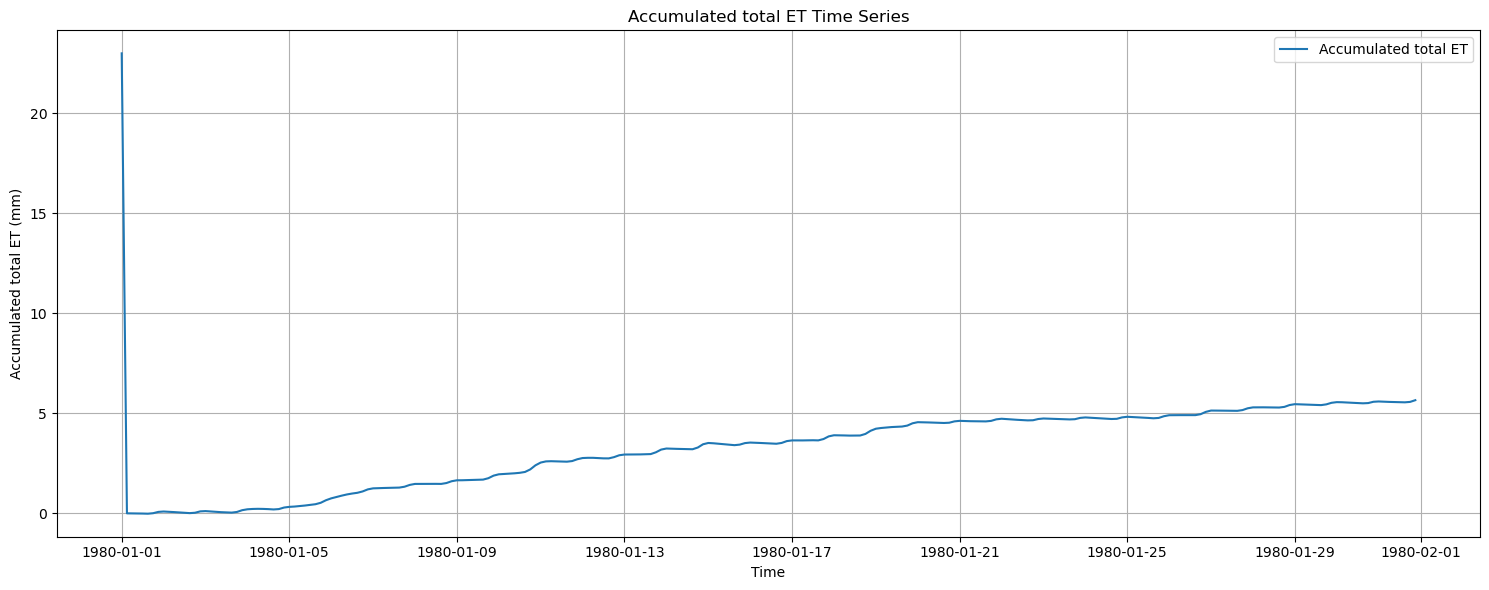

In [25]:
# Get the attributes for the label and title
units = ds_subset.attrs.get('units', 'Unknown Units')
long_name = ds_subset.attrs.get('long_name', 'Unknown Variable')

# Plot the user-defined variable
plt.figure(figsize=(15, 6))
plt.plot(ds_subset_df.index, ds_subset_df[ds_subset.name], label=f'{long_name}')

# Adding additional plot details
plt.title(f'{long_name} Time Series')
plt.xlabel('Time')
plt.ylabel(f'{long_name} ({units})')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

### 7. Save Data as a CSV File

In [26]:
# Specify the file path where you want to save the CSV file
file_path = f"{variable_name}_over_area.csv"

# Save the DataFrame to a CSV file
ds_subset_df.to_csv(file_path, index=True)  